In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import cm
from datetime import datetime

In [2]:
url_CSNV = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'https://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset>
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 -0.9375 -0.8125 ... -0.1875 -0.0625
  * s_w                     (s_w) float64 -1.0 -0.875 -0.75 ... -0.25 -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 ...
    lat_rho                 (eta_rho, xi_rho) float64 ...
    lon_u                   (eta_u, xi_u) float64 ...
    lat_u                   (eta_u, xi_u) float64 ...
    lon_v                   (eta_v, xi_v) float64 ...
    lat_v                   (eta_v, xi_v) float64 ...
    lon_psi                 (eta_psi, xi_psi) float64 ...
    lat_psi                 (eta_psi, xi_psi) float64 ...
  * ocean_time              (ocean_time) datetime64[ns] 2019-09-06T10:15:00.0...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 ...
    ndtfast                 int32 ...
    dt                      float64 ...
    dtfast                  float64 ...
    dstart                  datetime64[ns] ...
    nHIS                    int32 ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [57]:
# need itime, x, y, zeta, mask
x = ds_CSYV.eta_rho
y = ds_CSYV.xi_rho

In [58]:
# load initial and final bathymetry
bathi = ds_CSYV.bath[0,:,:].load()
bathf = ds_CSYV.bath[-1,:,:].load()

Contour intervals:  [-1  0  1  2  3]


Text(0.35, 0.9, 'Smoothed')

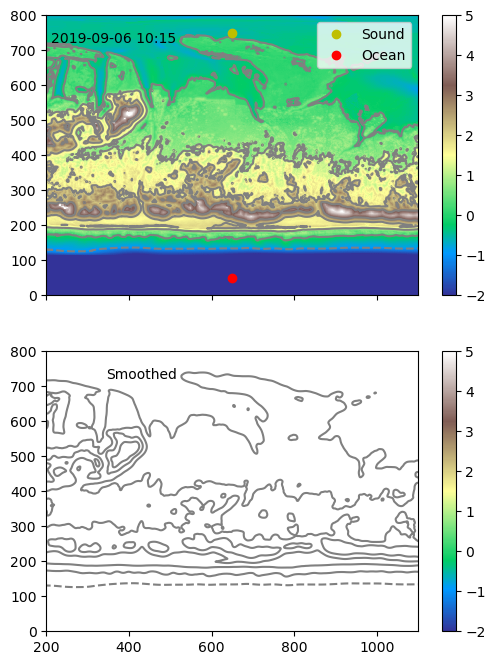

In [75]:
# smooth bathy
from scipy.ndimage import convolve
# experimenting with size of kernal suggest 15 is ok
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
bathis = convolve(bathi,k,mode='nearest')

# define contour intervals
cl = np.arange(-1,4,1)
print('Contour intervals: ',cl)

xs = 200
xe = 1100
ys = 0
ye = 800
fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(y,x,-bathi,cmap='terrain',vmin=-2,vmax=5)
m0c = ax0.contour(y,x,-bathi,cl,colors='gray',vmin=-2,vmax=5)
plt.colorbar(m0, ax=ax0)
ax0.plot(650,750,'oy',label='Sound')
ax0.plot(650,50,'or',label='Ocean')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
ax0.legend()
#m1 = ax1.pcolormesh(y,x,-bathis,cmap='terrain',vmin=-2,vmax=5)
m1c = ax1.contour(y,x,-bathis,cl,colors='gray',vmin=-2,vmax=5)
plt.colorbar(m1, ax=ax1)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.35, 0.9, 'Smoothed', transform=ax1.transAxes, ha='right')

In [92]:
t=ds_CSYV.ocean_time.load()
tstring = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
tstring

Index(['2019-09-06 10:15', '2019-09-06 10:30', '2019-09-06 10:45',
       '2019-09-06 11:00', '2019-09-06 11:15', '2019-09-06 11:30',
       '2019-09-06 11:45', '2019-09-06 12:00', '2019-09-06 12:15',
       '2019-09-06 12:30', '2019-09-06 12:45', '2019-09-06 13:00',
       '2019-09-06 13:14', '2019-09-06 13:29', '2019-09-06 13:44',
       '2019-09-06 13:59', '2019-09-06 14:14', '2019-09-06 14:29',
       '2019-09-06 14:45', '2019-09-06 15:00', '2019-09-06 15:15',
       '2019-09-06 15:30', '2019-09-06 15:45', '2019-09-06 16:00',
       '2019-09-06 16:15', '2019-09-06 16:30', '2019-09-06 16:45',
       '2019-09-06 17:00', '2019-09-06 17:15', '2019-09-06 17:30',
       '2019-09-06 17:45', '2019-09-06 18:00', '2019-09-06 18:15',
       '2019-09-06 18:30', '2019-09-06 18:45', '2019-09-06 19:00',
       '2019-09-06 19:15'],
      dtype='object')

In [85]:
ys, xs = 750,650
yo, xo = 50, 650
zs = ds_CSYV.zeta[:,ys,xs].load()
zo = ds_CSYV.zeta[:,yo,xo].load()

Sound zmax: 2.7950313091278076 at 2019-09-06T12:45:00.075094016
Diff max: 2.8085360527038574 at 2019-09-06T13:00:00.078527488
izsmax =  10 izdmax =  11


Text(0, 0.5, 'Difference (m)')

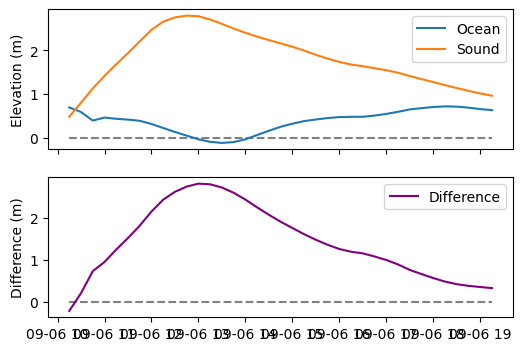

In [91]:
izsmax = np.argmax(zs.values)
tzsmax = t.values[izsmax]
zsmax = zs.values[izsmax]
print('Sound zmax: {} at {}'.format(zsmax, tzsmax) )

zdiff = zs.values - zo.values
izdmax = np.argmax(zdiff)
tdmax = t.values[izdmax]
zdmax = zdiff[izdmax]
print('Diff max: {} at {}'.format(zdmax, tdmax) )
print('izsmax = ', izsmax, 'izdmax = ', izdmax) 

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,4),sharex=True)
ax0.plot(t,np.zeros_like(zo),'--',c='gray')
ax0.plot(t,zo,label='Ocean')
ax0.plot(t,zs,label='Sound')
ax0.set_ylabel('Elevation (m)')
ax0.legend()

ax1.plot(t,np.zeros_like(zo),'--',c='gray')
ax1.plot(t,zs-zo,c='purple',label='Difference')
ax1.legend()
ax1.set_ylabel('Difference (m)')

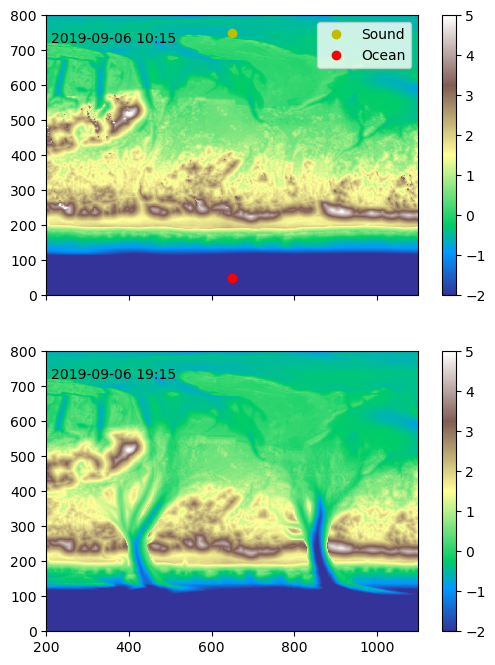

In [149]:
# Look at before/after bathy

xs = 200
xe = 1100
ys = 0
ye = 800

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(6,8),sharex=True)
m0 = ax0.pcolormesh(y,x,-bathi,cmap='terrain',vmin=-2,vmax=5)
plt.colorbar(m0, ax=ax0)
ax0.plot(650,750,'oy',label='Sound')
ax0.plot(650,50,'or',label='Ocean')
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.35, 0.9, '{}'.format(tstring[0]), transform=ax0.transAxes, ha='right')
ax0.legend()
m1 = ax1.pcolormesh(y,x,-bathf,cmap='terrain',vmin=-2,vmax=5)
plt.colorbar(m1, ax=ax1)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.35, 0.9, '{}'.format(tstring[-1]), transform=ax1.transAxes, ha='right')
fig.savefig('init_final_bathy.png', dpi=200, bbox_inches='tight')

In [95]:
# contour intervals
cl = np.arange(-1,4,1)
# time indices
ti = [0, 10, 31]
for i in ti:
    print(t.values[i])

2019-09-06T10:15:00.040762368
2019-09-06T12:45:00.075094016
2019-09-06T18:00:00.047192064


In [131]:
def mask_array( x, wdm ):
    s = wdm.shape
    wdmr = np.ravel(wdm)
    xr = np.ravel(x)
    xr[np.where(wdmr==0)]=np.nan
    xm = np.reshape( xr, s )
    return xm

def despeckle( x, iks = 3 ):
    # despeckle like this? This expands the NaN regions with a 3x3 matrix
    ks = np.ones((iks, iks)) / (iks*iks)
    xs = convolve(x,ks,mode='nearest')
    return xs

In [146]:
# pick a time index
idx = 20

# load bathy and smooth for contouring
bath = np.squeeze( ds_CSYV.bath[idx,:,:].load().values ) 
ik = 15
k = np.ones((ik, ik)) / (ik*ik)
baths = convolve(bath,k,mode='nearest')

# load water elevation and mask dry regions
zeta = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
wdm = np.squeeze( ds_CSYV.wetdry_mask_rho[idx,:,:].load().values )
zeta = despeckle( mask_array( zeta, wdm ) )

# load wave height and mask dry regions
hwave = np.squeeze( ds_CSYV.Hwave[idx,:,:].load().values )
hwave = despeckle( mask_array( hwave, wdm ) )

In [158]:
# load velocities
u = np.squeeze( ds_CSYV.ubar[idx,:,:].load().values )
v = np.squeeze( ds_CSYV.vbar[idx,:,:].load().values )

# decimate
dfac = 20
u = u[::dfac, ::dfac]
v = v[::dfac, ::dfac]
print(np.shape(u))
xd = x[::dfac]
yd = y[::dfac]
spd = np.sqrt( u**2 + v**2 )
np.shape(xd)

Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 
Error:curl error: Couldn't connect to server
curl error details: 


RuntimeError: NetCDF: I/O failure

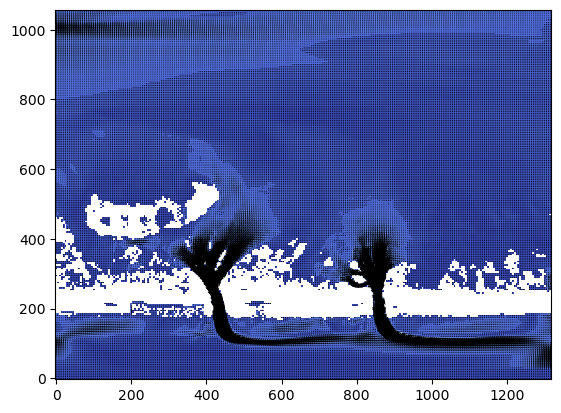

In [156]:
plt.pcolormesh(yd, xd, spd, cmap='coolwarm')
plt.quiver(yd, xd, u, v)

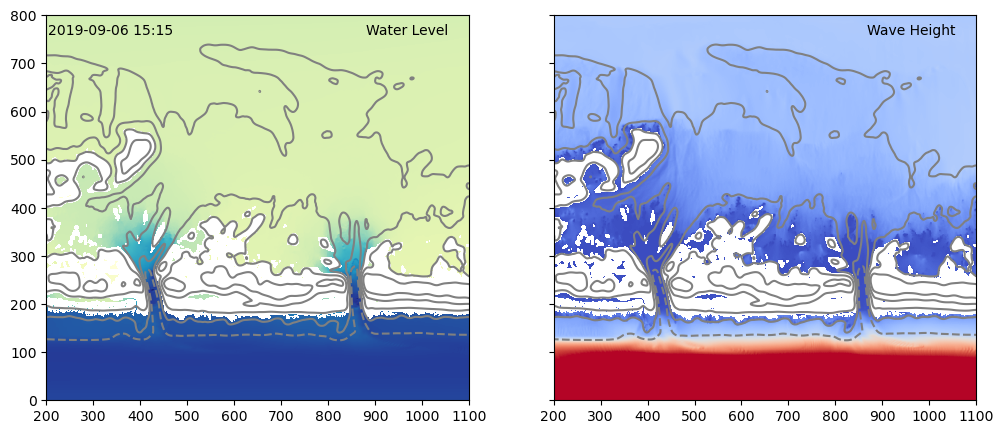

In [147]:
xs = 200
xe = 1100
ys = 0
ye = 800

figname = 'wl_hwave_{}.png'.format(idx)

fig, (ax0, ax1 ) = plt.subplots(1,2,figsize=(12,5),sharey=True)
m0 = ax0.pcolormesh(y,x,zeta,cmap='YlGnBu_r',vmin=0,vmax=2.5, alpha = 1)
c0 = ax0.contour(y,x,-baths,cl,colors='gray',vmin=-2,vmax=5)
ax0.set_xlim([xs, xe])
ax0.set_ylim([ys, ye])
ax0.text(0.3, 0.95, '{}'.format(tstring[idx]), transform=ax0.transAxes, ha='right')
ax0.text(0.95, 0.95, 'Water Level', transform=ax0.transAxes, ha='right')

m1 = ax1.pcolormesh(y,x,hwave,cmap='coolwarm',vmin=0,vmax=2.5, alpha = 1)
c1 = ax1.contour(y,x,-baths,cl,colors='gray',vmin=-2,vmax=5)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.text(0.95, 0.95, 'Wave Height',transform=ax1.transAxes, ha='right')
fig.savefig( figname, dpi=200, bbox_inches='tight' )